In [25]:
import glob
import os
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import cv2
import numpy as np

# Load car and not car data
cars = []
not_cars = []

# Get car paths
car_paths = ["./udacity-dataset/vehicles/GTI_Far"
"./udacity-dataset/vehicles/GTI_Left",
"./udacity-dataset/vehicles/GTI_MiddleClose",
"./udacity-dataset/vehicles/GTI_Right",
"./udacity-dataset/vehicles/KITTI_extracted"]

for i in xrange(0, len(car_paths)):
    car_path = car_paths[i]
    for file in glob.glob(os.path.join(car_path, "*.png")):
        cars.append(file)

# Get not car paths
not_car_paths = ["./udacity-dataset/non-vehicles/Extras",
"./udacity-dataset/non-vehicles/GTI"]

for i in xrange(0, len(not_car_paths)):
    not_car_path = not_car_paths[i]
    for file in glob.glob(os.path.join(not_car_path, "*.png")):
        not_cars.append(file)

# Extract HOG for features
def extract_hog_features(img, channel=0, orientations=9, pixels_per_cell=8, cells_per_block=2, transform_sqrt=False, visualise=False, feature_vector=True):
    if channel == "ALL":
        for j in xrange(0, img.shape[2]):
            hog_features = hog(img[:,:,j], orientations=orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell), cells_per_block=(cells_per_block, cells_per_block), transform_sqrt=transform_sqrt, visualise=visualise, feature_vector=feature_vector)
            hog_features = np.ravel(hog_features)
            print hog_features
    else:
        hog_features = hog(img[:,:,channel], orientations=orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell), cells_per_block=(cells_per_block, cells_per_block), transform_sqrt=transform_sqrt, visualise=visualise, feature_vector=feature_vector)

    return hog_features

def extract_bin_spacial_features(image, size=(32, 32)):
    return cv2.resize(image, size).ravel()


def extract_color_hist_features(image, nbins=32, bins_range=(0,256)):

    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features




def extract_training_features(files, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_features, hog_features):
    features = []

    for file in files:
        file_features = []
        image = cv2.imread(file)
        if spatial_feat:
            file_features.append(extract_bin_spacial_features(image))
        if hist_features:
            file_features.append(extract_color_hist_features(image))
        if hog_features:
            file_features.append(extract_hog_features(image))

        features.append(np.concatenate(file_features))
        
    return features


def extract_features(image, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_features, hog_features):
    
    file_features = []
    
    if spatial_feat:
        file_features.append(extract_bin_spacial_features(image))
    if hist_features:
        file_features.append(extract_color_hist_features(image))
    if hog_features:
        file_features.append(extract_hog_features(image))
        
    return np.concatenate(file_features)


def normalize_features(raw_features):
    normalized_features = []
    return normalized_features



In [26]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell #16
cell_per_block = 1 # HOG cells per block #2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [300, None] # Min and max in y to search in slide_window()


car_features = extract_training_features(cars, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
                                    spatial_feat, hist_feat, hog_feat)

not_car_features = extract_training_features(not_cars, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
                                    spatial_feat, hist_feat, hog_feat)

print "done extracting features"


done extracting features


In [8]:

X = np.vstack((car_features, not_car_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))

print X.shape


(16017, 1764)


In [9]:
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
import time

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print ('Configured Using:',orient,'orientations',
       pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print ('Feature vector length:', len(X_train[0]))

svc = LinearSVC()

t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print ("{} seconds to train classifier...".format(round(t2-t1, 5)))


/Users/kevin/.virtualenvs/vehicle_detection/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


('Configured Using:', 9, 'orientations', 16, 'pixels per cell and', 1, 'cells per block')
('Feature vector length:', 1764)
7.63707 seconds to train classifier...


In [33]:
from moviepy.editor import VideoFileClip

video = "datasets/Sunny/april21.avi"

video = VideoFileClip(video)

video.save_frame("test.jpeg")


In [37]:
def sliding_windows(img, x_range, y_range, window_size, xy_overlap_percent):
    windows = []
    
    x_start = x_range[0];
    x_end = x_range[1];
    y_start = y_range[0];
    y_end = y_range[1];
    
    # check values and use full image size if parameter is not given
    if (x_start == None):
        x_start = 0;
    if (x_end == None):
        x_end = img.shape[1];
    if (y_start == None):
        y_start = 0;
    if (y_end == None):
        y_end = img.shape[0];

    # window span
    x_span = x_end - x_start;
    y_span = y_end - y_start;

    # how much to move the window by each step
    x_step_size = window_size[0] * (1 - xy_overlap_percent[0])
    y_step_size = window_size[1] * (1 - xy_overlap_percent[1])

    # the region that overlaps
    x_overlap_region = window_size[0] * xy_overlap_percent[0]
    y_overlap_region = window_size[1] * xy_overlap_percent[1]

    # num of times the window fits in the span
    x_num_steps = np.int((x_span - x_overlap_region) / x_step_size)
    y_num_steps = np.int((y_span - y_overlap_region) / y_step_size)

    for y in range(y_num_steps):
        for x in range(x_num_steps):
            print "step: ", x
            window_start = (np.int(x * x_step_size + x_start), np.int(y * y_step_size + y_start))
            window_end = (np.int(window_start[0] + window_size[0]), np.int(window_start[1] + window_size[1]))
            windows.append((window_start, window_end))
        
    return windows

step:  0
step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9
step:  10
step:  11
step:  12
step:  13
step:  14
step:  15
step:  16
step:  17
step:  18
step:  19
step:  20
step:  0
step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9
step:  10
step:  11
step:  12
step:  13
step:  14
step:  15
step:  16
step:  17
step:  18
step:  19
step:  20
1
step:  0
step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9
step:  10
step:  11
step:  12
1
step:  0
step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9
0
0
('Windows Final', 2)
plotting image...


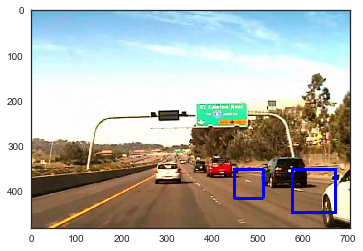

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
%matplotlib inline
import cv2
import seaborn as sns

image = cv2.imread("test.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

xy_window = [(64,64), (96,96), (128,128), (256,256)]
y_start_stop = [[350, 450], [350, 450], [350, None], [350, None]]

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# image = np.zeros((1280, 720, 3), dtype=np.uint8)

windows_temp = []
for i in range(len(xy_window)):
    windows = sliding_windows(image, [None, None], y_start_stop[i], 
                        xy_window[i], (0.5, 0.5))
    windows = search_windows(image, windows, svc, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
                                    spatial_feat, hist_feat, hog_feat)
    print(len(windows))
    windows_temp.append(windows) 


#Flatten windows_temp
windows_final = sum(windows_temp, [])

print("Windows Final",len(windows_final))
window_img = draw_boxes(image, windows_final, color=(0, 0, 255), thick=6)   
with sns.axes_style("white"):
    print "plotting image..."
#     fig = plt.figure()
#     plt.subplot(121)
    plt.imshow(window_img)
#     plt.title('Example Car Image')

In [42]:
def search_windows(img, windows, clf, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_features, hog_features):
    on_windows = []
    for window in windows:
        startx = window[0][0]
        starty = window[0][1]
        endx = window[1][0]
        endy = window[1][1]

        cropped = img[starty:endy, startx:endx]

        test_img = cv2.resize(cropped, (64, 64))
        features = extract_features(test_img, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_features=hist_features, hog_features=hog_features)

        # transform features to be fed into classifier
        test_features = X_scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)

        if prediction == 1:
            on_windows.append(window)

    return on_windows